In [66]:
import wandb
api = wandb.Api()


In [233]:
from pathlib import Path
import json
import pandas as pd
import re

source_ts_amounts= [n * 2048 * 2 for n in [4, 6, 8]]
source_ts = 'source-data timesteps'
algo = 'algorithm'
algo_mapping = {
    "3a2eb": "CQL",
    "ee24c": "BUN"
}

def generate():
    for path in Path('artifacts').rglob('*.json'):
        pattern = r"run-(\w+)_(\w+)-tablereturns:v\d+"
        with path.open() as f:
            table = json.load(f)
        df = pd.DataFrame(table['data'], columns=table['columns'])
        match = re.search(pattern, str(path))
        df[algo] = algo_mapping[match.group(1)]
        id_within_sweep = int(match.group(2))
        df[source_ts] = source_ts_amounts[id_within_sweep]
        yield df
        
df = pd.concat(list(generate()), ignore_index=True)

x = 'timestep'
y = 'discounted returns'

df = df.rename(columns={'returns': y})
df.loc[:, x] = df.groupby(['idx', algo, source_ts, 'step'])[x].cumsum()
def keep_last_n_steps(group, n=10):
    steps = sorted(group['step'].unique())
    top_n = steps[-n:]
    return group[group['step'].isin(top_n)]

df = df.groupby([algo, source_ts], group_keys=False).apply(keep_last_n_steps)
df = df.sort_values(by=[algo, source_ts, 'step', 'idx', x])

bin_size = 10
df[x] = (df[x] // bin_size ) * bin_size
df = df[df[x] < 800]
df

,episode,idx,discounted returns,timestep,step,algorithm,source-data timesteps
18470,0,0,0.000000,80,19618,BUN,16384
18490,1,0,0.642612,180,19618,BUN,16384
18510,2,0,0.773680,280,19618,BUN,16384
18530,3,0,1.922745,380,19618,BUN,16384
18550,4,0,1.990000,480,19618,BUN,16384
...,...,...,...,...,...,...,...
2230,1,19,1.000937,180,36000,CQL,32768
2250,2,19,0.000000,280,36000,CQL,32768
2270,3,19,1.990000,380,36000,CQL,32768
2290,4,19,0.000000,480,36000,CQL,32768


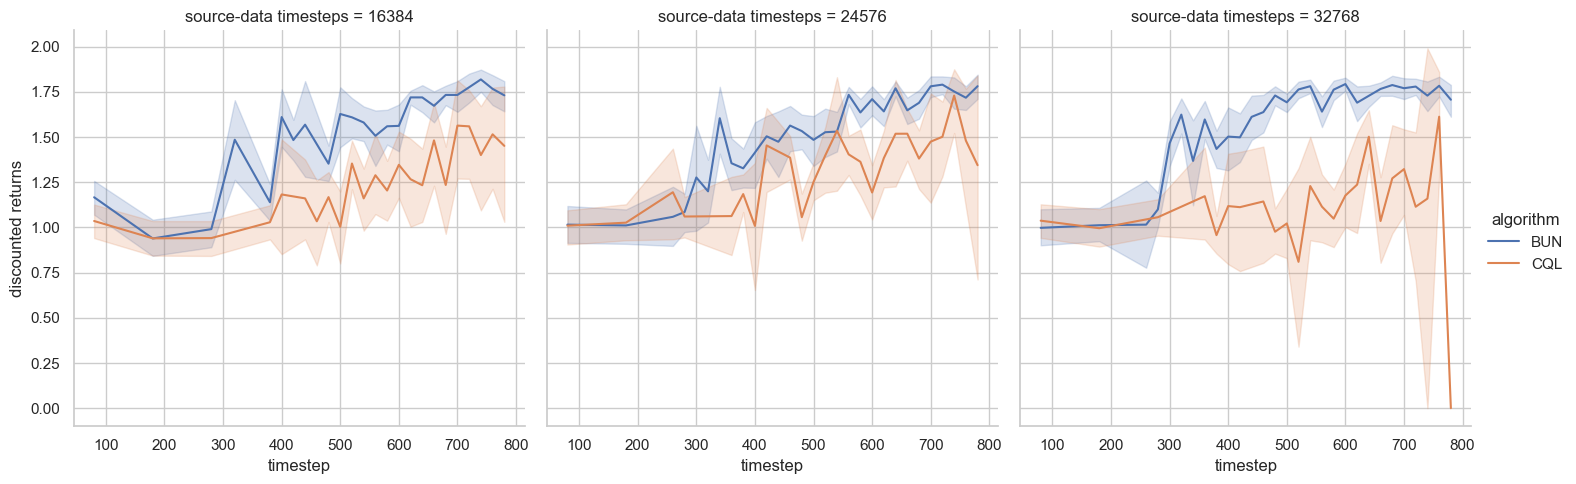

In [234]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


g = sns.relplot(x=x, y=y, kind='line', hue=algo, data=df, col=source_ts)